In [18]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.integrate import odeint
plt.rc('font', family='Times New Roman')


In [3]:
soil_moisture = []
for month in range(1, 10):
    f = nc.Dataset("../Data/2017_sm/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20170"+str(month)+"01000000-fv04.5.nc")
    all_vars = f.variables.keys()   # get all keys
    all_vars_info = f.variables.items()   # output: <class 'dict_items'>
    sm = f['sm'][:].data
    soil_moisture.append(sm[0][193][249])
for month in range(10, 13):
    f = nc.Dataset("../Data/2017_sm/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-2017"+str(month)+"01000000-fv04.5.nc")
    all_vars = f.variables.keys()   # get all keys
    all_vars_info = f.variables.items()   # output: <class 'dict_items'>
    sm = f['sm'][:].data
    soil_moisture.append(sm[0][193][249])
for month in range(1, 10):
    f = nc.Dataset("../Data/2018_sm/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20180"+str(month)+"01000000-fv04.5.nc")
    all_vars = f.variables.keys()   # get all keys
    all_vars_info = f.variables.items()   # output: <class 'dict_items'>
    sm = f['sm'][:].data
    processed_data = 0
    if(sm[0][193][249] == -9999.):
        _ = 0
        for j in range (-15, 15):
            if(sm[0][193][249+j] != -9999.):
                if(_ == 0):
                    _ = sm[0][193][249+j]
                else:
                    _ = (sm[0][193][249+j] + _)/2
        processed_data = _
    if(sm[0][193][249] != -9999.):
        soil_moisture.append(sm[0][193][249])
    else:
        soil_moisture.append(processed_data)
for month in range(10, 13):
    f = nc.Dataset("../Data/2018_sm/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-2018"+str(month)+"01000000-fv04.5.nc")
    all_vars = f.variables.keys()   # get all keys
    all_vars_info = f.variables.items()   # output: <class 'dict_items'>
    sm = f['sm'][:].data
    processed_data = 0
    if(sm[0][193][249] == -9999.):
        _ = 0
        for j in range (-15, 15):
            if(sm[0][193][249+j] != -9999.):
                if(_ == 0):
                    _ = sm[0][193][249+j]
                else:
                    _ = (sm[0][193][249+j] + _)/2
        processed_data = _
    if(sm[0][193][249] != -9999.):
        soil_moisture.append(sm[0][193][249])
    else:
        soil_moisture.append(processed_data)
for index, data in enumerate(soil_moisture):
    if(data == 0):
        data = (soil_moisture[index-1] + soil_moisture[index+1])/2
        soil_moisture[index] = data

In [4]:
air_pressure_california = pd.DataFrame(pd.read_csv("../Data/California_data/AirPressure.csv"))
air_pressure_list = air_pressure_california.values[0].tolist() + air_pressure_california.values[1].tolist()
rainfall_california = pd.DataFrame(pd.read_csv("../Data/California_data/ObservedRainfall.csv"))
rainfall_list = rainfall_california.values[0].tolist() + rainfall_california.values[1].tolist()
temperature_california = pd.DataFrame(pd.read_csv("../Data/California_data/Temperature.csv"))
temperature_list = temperature_california.values[0].tolist() + temperature_california.values[1].tolist()
rainfall_list[11] = (rainfall_list[12] + rainfall_list[10])/2
rainfall_list[13] = (rainfall_list[12] + rainfall_list[14])/1.5
rainfall_list[-1] = (rainfall_list[-2])*1.5
rainfall_list[0], rainfall_list[1] = rainfall_list[1], rainfall_list[0]
rainfall_list[0], rainfall_list[2] = rainfall_list[2], rainfall_list[0]
rainfall_list[3] = (rainfall_list[2] + rainfall_list[4])/2
for i in range(4, 11):
    rainfall_list[i] = (rainfall_list[i-1] + rainfall_list[i+1])/2 
for i in range(16, 22):
    rainfall_list[i] = (rainfall_list[i-1] + rainfall_list[i+1])/2 
rainfall_list = [i/3 for i in rainfall_list]
print(rainfall_list)

[0.8879569893333333, 3.75411111, 3.369066666666667, 1.798404301, 0.937178341, 0.4769762673333333, 0.25532146699999997, 0.178574712, 0.158195402, 0.45915146450000005, 0.78304347425, 1.106935484, 1.4537634410000002, 2.3321146953333334, 2.044408602, 0.569032258, 0.2994605735, 0.15869580391666666, 0.08079234645833333, 0.048896173229166666, 0.13002279928125, 0.6031225108072916, 1.0762222223333333, 1.6143333335]


In [5]:
air_pressure_list, rainfall_list, temperature_list = np.array(air_pressure_list), np.array(rainfall_list), np.array(temperature_list)
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s
model = linear_model.LinearRegression()
df_train = pd.DataFrame({'rainfall': rainfall_list , 'temperature': np.log(temperature_list), 'soil_moisture': soil_moisture})
model.fit(df_train[['rainfall']], df_train['soil_moisture'])
print(model.coef_, model.intercept_)

[0.04280183] 0.14715905345465796


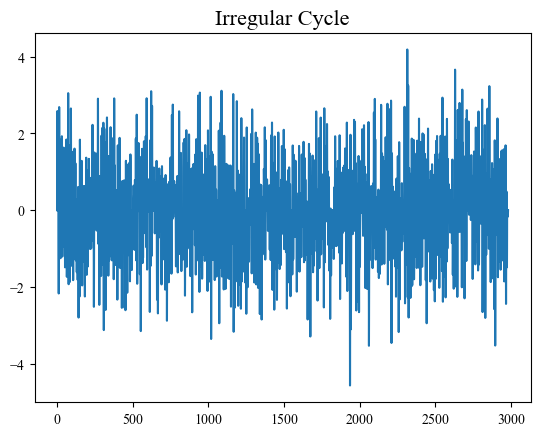

In [6]:
### Then generate the cycle.
def generate_cycle(A, period,phase, adding):
    for index, p in enumerate(period):
        if p < 0:
            period[index] = -p
    def sin_function(x, A, T):
        return A * np.sin( 2 * np.pi / T * (x + phase)) + adding
    total_step = 1000 # 100 T
    total_distance = 0
    cycle = []
    for step in range(total_step):
        half_period = period[step] / 2
        if(step % 2 == 0):
            sub_step_list = np.linspace(0, half_period, 100).tolist()
            for sub_step in sub_step_list:
                cycle.append(sin_function(sub_step, A[step], period[step]))
            total_distance += half_period
        else:
            sub_step_list = np.linspace(half_period, period[step], 100).tolist()
            for sub_step in sub_step_list:
                cycle.append(sin_function(sub_step, A[step], period[step]))
            total_distance += half_period
    return cycle, total_distance
A = np.random.normal(1, 1, 5000)
period = np.random.normal(2 * np.pi, 10, 5000)
period = [-p for p in period if p < 0] + [p for p in period if p > 0]
cycle, distance = generate_cycle(A, period, 0, 0)
x = np.linspace(0, distance, len(cycle))
plt.title("Irregular Cycle", fontdict={'size': 16})

plt.plot(x, cycle, 0)


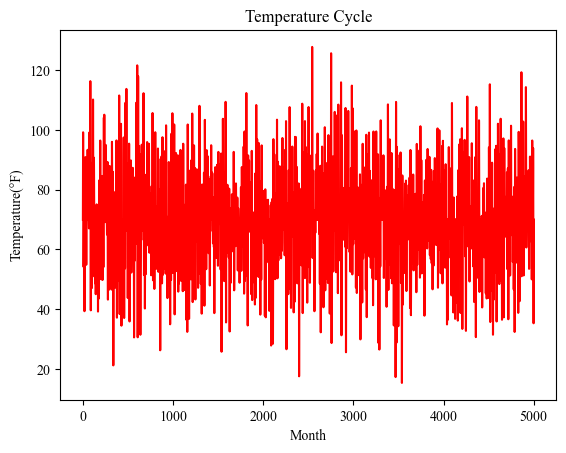

In [7]:
A = np.random.normal(12, 15, 5000)
period = np.random.normal(12, 15, 5000)
period = [-p for p in period if p < 0] + [p for p in period if p > 0]
adding = 70
temp_cycle,temp_distance = generate_cycle(A, period, 0, adding)
x= np.arange(0, 5000, 0.05)
plt.title("Temperature Cycle")
plt.xlabel("Month")
plt.ylabel("Temperature(°F)")
plt.plot(x, temp_cycle, 'r')
plt.show()

In [8]:
print(temp_distance)

4283.824637281001


In [9]:

A = np.random.normal(5/3, 5, 5000)
period = np.random.normal(12, 15, 5000)
period = [-p for p in period if p < 0] + [p for p in period if p > 0]
adding = 0
rainfall_cycle,rainfall_distance = generate_cycle(A, period, np.pi/2 ,adding)
rainfall_cycle = np.array(rainfall_cycle)


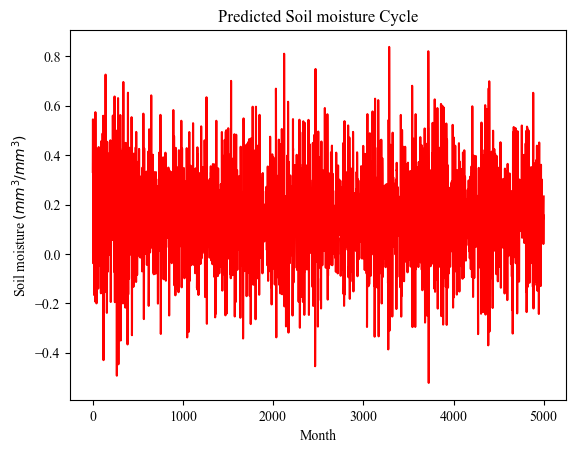

In [10]:
temp_cycle, rainfall_cycle = np.array(temp_cycle), np.array(rainfall_cycle)
df_predict = pd.DataFrame({'rainfall': rainfall_cycle})
moisture_predicted_data = model.predict(df_predict)
x= np.arange(0, 5000, 0.05)
plt.title("Predicted Soil moisture Cycle")
plt.xlabel("Month")
plt.ylabel(r"Soil moisture $(mm^3/mm^3)$")
plt.plot(x, model.predict(df_predict), 'r')

In [11]:
moisture_predicted_data = [round(i, 3) for i in moisture_predicted_data]


In [12]:
cooperation_matrix = pd.read_csv("../Data/judge_matrix/Cooperation.csv")
matrix = []
for value in cooperation_matrix.values:
    matrix.append(value.tolist()[1:])
eigenvalues, eigenvectors = np.linalg.eig(matrix)
max_eigenvalue = np.real(max(eigenvalues))
max_eigenvalue_index = np.where(eigenvalues == max_eigenvalue)[0][0]
print("The max eigenvalue is: {}".format(max_eigenvalue))
print("The index of the max eigenvalue is: {}".format(max_eigenvalue_index))
### Find the corresponding eigenvector, use np.real to get the real part of the complex number
max_eigenvector = np.real(eigenvectors[:, max_eigenvalue_index])
### Normalize the eigenvector
max_eigenvector = max_eigenvector / np.sum(max_eigenvector)
print("The weights are: {}".format(max_eigenvector))
### Test the consistency
RI_list = [0, 0, 0.58, 0.9, 1.12, 1.24, 1.32, 1.41, 1.45, 1.49]
CI = round((max_eigenvalue - len(matrix)) / (len(matrix) - 1),2)
print("The consistency index is: {}".format(CI))
RI = round(RI_list[len(matrix) - 1],2)
print("The random index is: {}".format(RI))
CR = round(CI / RI, 2)
print("The consistency ratio is: {}".format(CR))

The max eigenvalue is: 7.443718058910241
The index of the max eigenvalue is: 0
The weights are: [0.19425374 0.19425374 0.06770099 0.19425374 0.04705627 0.19425374
 0.10822778]
The consistency index is: 0.07
The random index is: 1.32
The consistency ratio is: 0.05


In [13]:
competition_matrix = pd.read_csv("../Data/judge_matrix/Competition.csv")
matrix = []
for value in competition_matrix.values:
    matrix.append(value.tolist()[1:])
eigenvalues, eigenvectors = np.linalg.eig(matrix)
max_eigenvalue = np.real(max(eigenvalues))
max_eigenvalue_index = np.where(eigenvalues == max_eigenvalue)[0][0]
print("The max eigenvalue is: {}".format(max_eigenvalue))
print("The index of the max eigenvalue is: {}".format(max_eigenvalue_index))
### Find the corresponding eigenvector, use np.real to get the real part of the complex number
max_eigenvector = np.real(eigenvectors[:, max_eigenvalue_index])
### Normalize the eigenvector
max_eigenvector = max_eigenvector / np.sum(max_eigenvector)
print("The weights are: {}".format(max_eigenvector))
### Test the consistency
RI_list = [0, 0, 0.58, 0.9, 1.12, 1.24, 1.32, 1.41, 1.45, 1.49]
CI = (max_eigenvalue - len(matrix)) / (len(matrix) - 1)
print("The consistency index is: {}".format(CI))
RI =  RI_list[len(matrix) - 1]
print("The random index is: {}".format(RI))
CR =  CI / RI
print("The consistency ratio is: {}".format(CR))

The max eigenvalue is: 7.000040014636708
The index of the max eigenvalue is: 0
The weights are: [0.06363875 0.06274494 0.23172846 0.05329755 0.16684449 0.07415311
 0.3475927 ]
The consistency index is: 6.6691061180179645e-06
The random index is: 1.32
The consistency ratio is: 5.052353119710579e-06


In [14]:
plant_info = pd.read_csv("../Data/plant_info/PlantInfo.csv")
plant_data_frame = pd.DataFrame(plant_info)
plants_moisture = plant_data_frame["Suitable Moisture(inch/year)"].values.tolist()
plants_min_rainfall = [float(moisture.split(" ")[0]) for moisture in plants_moisture]
plants_max_rainfall= [float(moisture.split(" ")[1]) for moisture in plants_moisture]
species_min_moisture = []
species_max_moisture = []
for specie_min_moisture in plants_min_rainfall:
    specie_min_rainfall = [specie_min_moisture] * len(rainfall_cycle)
    specie_min_rainfall = np.array(specie_min_rainfall)/12
    specie_min_moisture = model.predict(pd.DataFrame({'rainfall': specie_min_rainfall}))
    species_min_moisture.append(specie_min_moisture)
for specie_max_moisture in plants_max_rainfall:
    specie_max_rainfall = [specie_max_moisture] * len(rainfall_cycle)
    specie_max_rainfall = np.array(specie_max_rainfall)/12
    specie_max_moisture = model.predict(pd.DataFrame({'rainfall': specie_max_rainfall}))
    species_max_moisture.append(specie_max_moisture)
species_min_moisture = [i[0] for i in species_min_moisture]
species_max_moisture = [i[0] for i in species_max_moisture]
species_min_moisture = [round(i, 2) for i in species_min_moisture]
species_max_moisture = [round(i, 2) for i in species_max_moisture]
print(species_min_moisture, species_max_moisture)

[0.18, 0.18, 0.29, 0.18, 0.26, 0.19, 0.33] [0.22, 0.21, 0.36, 0.2, 0.29, 0.22, 0.5]


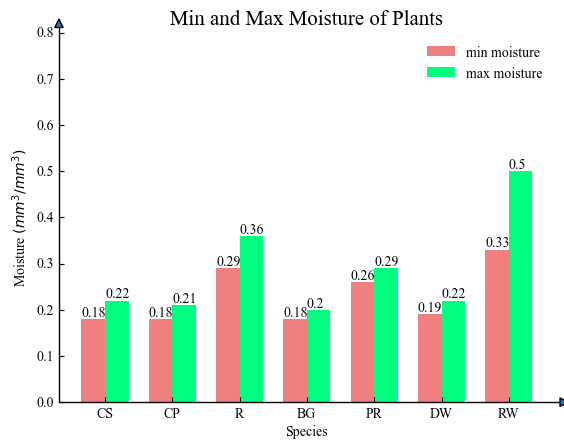

In [15]:
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as axisartist
import numpy as np


def auto_label(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height), # put the detail data
                    xy=(rect.get_x() + rect.get_width() / 2, height), # get the center location.
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


def auto_text(rects):
    for rect in rects:
        ax.text(rect.get_x(), rect.get_height(), rect.get_height(), ha='left', va='bottom')

labels = ["CS", "CP", "R", "BG", "PR", "DW", "RW"]

men_means = species_min_moisture
women_means = species_max_moisture

index = np.arange(len(labels))
width = 0.35

fig = plt.figure()
ax = axisartist.Subplot(fig, 111)
fig.add_axes(ax)
ax.axis["bottom"].set_axisline_style("-|>", size = 1.5)
ax.axis["left"].set_axisline_style("-|>", size = 1.5)
ax.axis["top"].set_visible(False)
ax.axis["right"].set_visible(False)

rect1 = ax.bar(index - width / 2, men_means, color ='lightcoral', width=width, label ='min moisture')
rect2 = ax.bar(index + width / 2, women_means, color ='springgreen', width=width, label ='max moisture')

ax.set_title('Min and Max Moisture of Plants', fontdict={'size':15})
ax.set_xticks(ticks=index)
ax.set_xticklabels(labels)
ax.set_ylabel(r'Moisture $(mm^3/ mm^{3})$')


ax.set_ylim(0, 0.8)
# auto_label(rect1)
# auto_label(rect2)
auto_text(rect1)
auto_text(rect2)

ax.legend(loc='upper right', frameon=False)
# fig.tight_layout()
ax.set_xlabel("Species", loc="right")
plt.show()


0.03 0.37000000000000033
0.03 0.37000000000000033
0.05 0.8000000000000007
0.07 0.3100000000000002
0.1 0.4500000000000003
0.03 0.37000000000000033
0.02 1.209000000000001


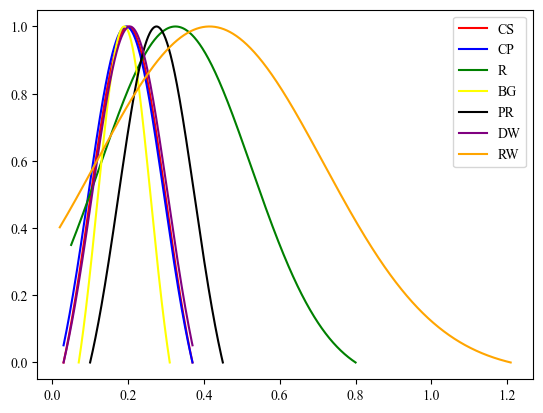

In [16]:
def normal_distribution(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-1 / 2 * ((x - mu) / sigma) ** 2)

cs_x_distribution = np.arange(0.03, 0.371, 0.001)
cs_y_distribution = normal_distribution(cs_x_distribution, 0.2, 0.1)
cs_y_distribution = [(i-min(cs_y_distribution)) / (max(cs_y_distribution) - min(cs_y_distribution))  for i in cs_y_distribution]
print(cs_x_distribution[0], cs_x_distribution[-1])
cs_x_distribution = [(round(i, 3)) for i in cs_x_distribution]
cp_x_distribution = np.arange(0.03, 0.371, 0.001)
cp_y_distribution = normal_distribution(cp_x_distribution, 0.195, 0.1)
cp_y_distribution = [(i-min(cp_y_distribution)) / (max(cp_y_distribution) - min(cp_y_distribution))  for i in cp_y_distribution]
print(cp_x_distribution[0], cp_x_distribution[-1])
cp_x_distribution = [(round(i, 3)) for i in cp_x_distribution]
R_x_distribution = np.arange(0.05, 0.801, 0.001)
R_y_distribution = normal_distribution(R_x_distribution, 0.325, 0.2)
R_y_distribution = [(i-min(R_y_distribution)) / (max(R_y_distribution) - min(R_y_distribution))  for i in R_y_distribution]
print(R_x_distribution[0], R_x_distribution[-1])
R_x_distribution = [(round(i, 3)) for i in R_x_distribution]
BG_x_distribution = np.arange(0.07, 0.311, 0.001)
BG_y_distribution = normal_distribution(BG_x_distribution, 0.19, 0.07)
BG_y_distribution = [(i-min(BG_y_distribution)) / (max(BG_y_distribution) - min(BG_y_distribution))  for i in BG_y_distribution]
print(BG_x_distribution[0], BG_x_distribution[-1])
BG_x_distribution = [(round(i, 3)) for i in BG_x_distribution]
PR_x_distribution = np.arange(0.1, 0.451, 0.001)
PR_y_distribution = normal_distribution(PR_x_distribution, 0.275, 0.1)
PR_y_distribution = [(i-min(PR_y_distribution)) / (max(PR_y_distribution) - min(PR_y_distribution))  for i in PR_y_distribution]
print(PR_x_distribution[0], PR_x_distribution[-1])
PR_x_distribution = [(round(i, 3)) for i in PR_x_distribution]
DW_x_distribution = np.arange(0.03, 0.371, 0.001)
DW_y_distribution = normal_distribution(DW_x_distribution, 0.205, 0.1)
DW_y_distribution = [(i-min(DW_y_distribution)) / (max(DW_y_distribution) - min(DW_y_distribution))  for i in DW_y_distribution]
print(DW_x_distribution[0], DW_x_distribution[-1])
DW_x_distribution = [(round(i, 3)) for i in DW_x_distribution]
RW_x_distribution = np.arange(0.02, 1.21, 0.001)
RW_y_distribution = normal_distribution(RW_x_distribution, 0.415, 0.3)
RW_y_distribution = [(i-min(RW_y_distribution)) / (max(RW_y_distribution) - min(RW_y_distribution))  for i in RW_y_distribution]
print(RW_x_distribution[0], RW_x_distribution[-1])
RW_x_distribution = [(round(i, 3)) for i in RW_x_distribution]
x_ranges = [[0.03, 0.37], [0.03, 0.37], [0.05, 0.8], [0.07, 0.31], [0.1, 0.45], [0.03, 0.37], [0.02, 1.2]]
plt.plot(cs_x_distribution, cs_y_distribution, color='red', label='CS')
plt.plot(cp_x_distribution, cp_y_distribution, color='blue', label='CP')
plt.plot(R_x_distribution, R_y_distribution, color='green', label='R')
plt.plot(BG_x_distribution, BG_y_distribution, color='yellow', label='BG')
plt.plot(PR_x_distribution, PR_y_distribution, color='black', label='PR')
plt.plot(DW_x_distribution, DW_y_distribution, color='purple', label='DW')
plt.plot(RW_x_distribution, RW_y_distribution, color='orange', label='RW')
plt.legend()
plt.show()


In [25]:

def softmax(x):
    return np.exp(np.array(x)) / np.sum(np.exp(x), axis=0).tolist()

def differential_function(variable_list, timespan, num_of_species, x_range_list, distribution_list ,growth_rate_list, moisture, N_list, competition_matrix_list, cooperation_matrix_list):
    polynomials = []
    real_growth_rate = []
    percentage = []
    for i in range(num_of_species):
        if (moisture>= x_range_list[i][0]) and (moisture<= x_range_list[i][1]):
            percentage.append(distribution_list[i][moisture])
        else:
            percentage.append(0)
    real_growth_rate = [i * j for i, j in zip(growth_rate_list, percentage)]
    compete_list = []
    coop_list = []
    for i in range(num_of_species):
        compete_list.append(sum(1/N_list[j] * competition_matrix_list[i][j] * variable_list[j] for j in range(num_of_species) if j != i))
        coop_list.append(sum(1/N_list[j] * cooperation_matrix_list[i][j] * variable_list[j] for j in range(num_of_species) if j != i))
    # compete_list, coop_list = softmax(compete_list), softmax(coop_list)
    for i in range(num_of_species):
        poly = real_growth_rate[i] * variable_list[i] * (1 - variable_list[i]/N_list[i] - compete_list[i] + coop_list[i])
        polynomials.append(poly)
    return np.array(polynomials)

time = np.arange(0, 2000, 0.05)
timespan = np.arange(0, 0.05, 0.01)
variable_list = [10, 10, 10, 10, 10, 10, 10]
# N_list = (np.array([100,100,100,200,200,50,50])/10).tolist()
N_list=[100,100,100,200,200,50,50]
num_of_species = 7
x_range_list = x_ranges
distribution_list=[]
distribution_list.append(dict(zip(cs_x_distribution, cs_y_distribution)))
distribution_list.append(dict(zip(cp_x_distribution, cp_y_distribution)))
distribution_list.append(dict(zip(R_x_distribution, R_y_distribution)))
distribution_list.append(dict(zip(BG_x_distribution, BG_y_distribution)))
distribution_list.append(dict(zip(PR_x_distribution, PR_y_distribution)))
distribution_list.append(dict(zip(DW_x_distribution, DW_y_distribution)))
distribution_list.append(dict(zip(RW_x_distribution, RW_y_distribution)))
growth_rate_list = plant_info['Growth Rate'].values.tolist()
competition_matrix = pd.read_csv("../Data/judge_matrix/Competition.csv")
competition_matrix_list = []
for value in competition_matrix.values:
    competition_matrix_list.append(value.tolist()[1:])
cooperation_matrix = pd.read_csv("../Data/judge_matrix/Cooperation.csv")
cooperation_matrix_list = []
for value in cooperation_matrix.values:
    cooperation_matrix_list.append(value.tolist()[1:])
solution_list = []
for timestep in range(len(time)):
    moisture = moisture_predicted_data[timestep]
    solution = odeint(differential_function, variable_list, timespan, args=(num_of_species, x_range_list, distribution_list, growth_rate_list, moisture, N_list, competition_matrix_list, cooperation_matrix_list))
    solution = solution[-1]
    variable_list = solution.tolist()
    solution_list.append(solution)
cs_trend, cp_trend, R_trend, BG_trend, PR_trend, DW_trend, RW_trend = [i[0] for i in solution_list], [i[1] for i in solution_list], [i[2] for i in solution_list], [i[3] for i in solution_list], [i[4] for i in solution_list], [i[5] for i in solution_list], [i[6] for i in solution_list]

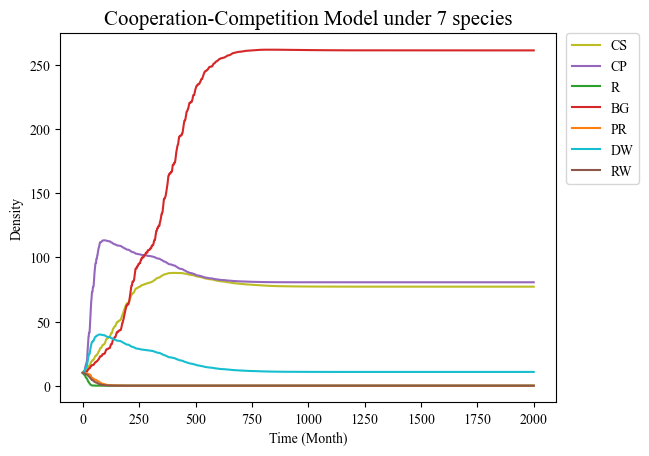

In [27]:
plt.plot(time, cs_trend, color='tab:olive', label='CS')
plt.plot(time, cp_trend, color='tab:purple', label='CP')
plt.plot(time, R_trend, color='tab:green', label='R')
plt.plot(time, BG_trend, color='tab:red', label='BG')
plt.plot(time, PR_trend, color='tab:orange', label='PR')
plt.plot(time, DW_trend, color='tab:cyan', label='DW')
plt.plot(time, RW_trend, color='tab:brown', label='RW')
# plt.xlim(0,600)
plt.title("Cooperation-Competition Model under 7 species", fontdict={'size':15})
plt.xlabel("Time (Month)")
plt.ylabel("Density")
plt.legend(loc=2, bbox_to_anchor=(1.02,1.0),borderaxespad = 0.)
plt.show()